<a href="https://colab.research.google.com/github/anahitaoladan/Artificial-Intelligence/blob/main/%D9%BE%D8%B1%D9%88%DA%98%D9%87_%D9%86%D9%87%D8%A7%DB%8C%DB%8C_%D9%87%D9%88%D8%B4%20%D9%85%D8%B5%D9%86%D9%88%D8%B9%DB%8Cipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install gdown
import gdown, os

url = "https://drive.google.com/file/d/1jCk3J7MRFHRWbKemQUla_YO2LpDgUo3f/view?usp=share_link"
out = "data.csv"

if not os.path.exists(out):
    gdown.download(url=url, output=out, quiet=False, fuzzy=True)

!ls -lh

Downloading...
From: https://drive.google.com/uc?id=1jCk3J7MRFHRWbKemQUla_YO2LpDgUo3f
To: /content/data.csv
100%|██████████| 529k/529k [00:00<00:00, 38.6MB/s]

total 524K
-rw-r--r-- 1 root root 517K Sep  8 14:47 data.csv
drwxr-xr-x 1 root root 4.0K Sep  5 13:36 sample_data


/tmp/ipython-input-2235482649.py:37: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X[c] = pd.to_numeric(X[c], errors="ignore")


==== Summary ====
Train: (3539, 36),  Test: (885, 36)
Classes: ['Dropout', 'Enrolled', 'Graduate']
Test Accuracy: 0.7492

==== Classification Report ====
              precision    recall  f1-score   support

     Dropout       0.80      0.74      0.77       284
    Enrolled       0.48      0.40      0.44       159
    Graduate       0.79      0.88      0.83       442

    accuracy                           0.75       885
   macro avg       0.69      0.67      0.68       885
weighted avg       0.74      0.75      0.74       885



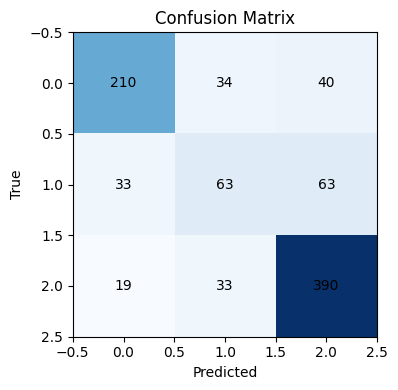

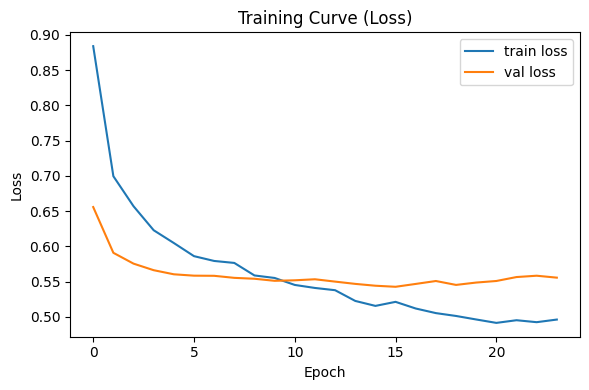

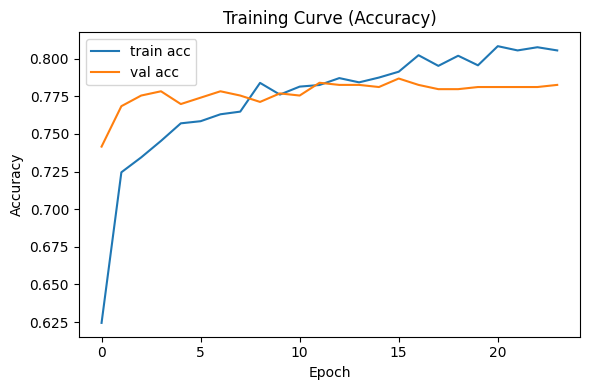

Saved model -> mlp_model.keras


In [3]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

np.random.seed(42)
tf.random.set_seed(42)

def read_csv_safe(path):
    for sep in [";", ","]:
        try:
            df = pd.read_csv(path, sep=sep, engine="python")
            if df.shape[1] > 1: return df
        except: pass
    df = pd.read_csv(path, header=None, engine="python")
    parts = df.iloc[:,0].astype(str).str.split(";", expand=True)
    header = parts.iloc[0].tolist()
    parts = parts.drop(index=0).reset_index(drop=True)
    parts.columns = header
    return parts

assert os.path.exists("data.csv"), "فایل data.csv پیدا نشد. سلول gdown را اجرا کن."
df = read_csv_safe("data.csv")

tcol = [c for c in df.columns if c.strip().lower() == "target"]
assert len(tcol)==1, f"ستون Target پیدا نشد. ستون‌ها: {list(df.columns)[:10]}..."
tcol = tcol[0]

df = df.dropna(how="all").drop_duplicates().reset_index(drop=True)

X = df.drop(columns=[tcol]).copy()
y = df[tcol].copy()

for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors="ignore")

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

for c in num_cols:
    if X[c].isna().any(): X[c] = X[c].fillna(X[c].median())
for c in cat_cols:
    if X[c].isna().any(): X[c] = X[c].fillna(X[c].mode().iloc[0])

for c in cat_cols:
    le = LabelEncoder()
    X[c] = le.fit_transform(X[c].astype(str))

scaler = StandardScaler()
if len(num_cols)>0:
    X[num_cols] = scaler.fit_transform(X[num_cols])

strat = y if y.nunique()>1 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=strat
)

le_y = LabelEncoder()
y_train_enc = le_y.fit_transform(y_train)
y_test_enc  = le_y.transform(y_test)
n_classes   = len(le_y.classes_)
n_features  = X_train.shape[1]

model = models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid") if n_classes==2 else layers.Dense(n_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy" if n_classes==2 else "sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

es = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
hist = model.fit(
    X_train.values, y_train_enc,
    validation_split=0.2,
    epochs=40,
    batch_size=64,
    callbacks=[es],
    verbose=0
)

if n_classes==2:
    y_pred_prob = model.predict(X_test.values, verbose=0).ravel()
    y_pred_enc  = (y_pred_prob>0.5).astype(int)
else:
    y_pred_prob = model.predict(X_test.values, verbose=0)
    y_pred_enc  = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test_enc, y_pred_enc)

print("==== Summary ====")
print(f"Train: {X_train.shape},  Test: {X_test.shape}")
print(f"Classes: {list(le_y.classes_)}")
print(f"Test Accuracy: {acc:.4f}\n")

print("==== Classification Report ====")
print(classification_report(y_test_enc, y_pred_enc, target_names=le_y.classes_))

cm = confusion_matrix(y_test_enc, y_pred_enc)
fig1 = plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for (i,j),v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.tight_layout()
plt.show()

fig2 = plt.figure(figsize=(6,4))
plt.plot(hist.history["loss"], label="train loss")
plt.plot(hist.history["val_loss"], label="val loss")
plt.title("Training Curve (Loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

fig3 = plt.figure(figsize=(6,4))
plt.plot(hist.history["accuracy"], label="train acc")
plt.plot(hist.history["val_accuracy"], label="val acc")
plt.title("Training Curve (Accuracy)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

model.save("mlp_model.keras")
print("Saved model -> mlp_model.keras")